### Crime severity prediction based on time and location

Importing Libraries and loading the data

In [717]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [718]:
#Loading the dataset
crimes_df = pd.read_csv('Crimes-2019_to_2021.csv')
crimes_df.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11552667,JC100123,1/1/19 0:00,004XX N STATE ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,42.0,8.0,6,1176302.0,1903096.0,2019,1/10/19 15:16,41.889453,-87.627995,"(41.889453169, -87.627994833)"
1,11552674,JC100085,1/1/19 0:00,092XX S NORMAL AVE,910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,21.0,73.0,7,1174586.0,1843723.0,2019,1/10/19 15:16,41.726566,-87.636066,"(41.726566477, -87.636065622)"
2,11552709,JC100020,1/1/19 0:00,044XX S WASHTENAW AVE,486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,15.0,58.0,08B,1159112.0,1875020.0,2019,1/10/19 15:16,41.812780,-87.691894,"(41.812780011, -87.691893746)"
3,11552758,JC100058,1/1/19 0:00,063XX S MARSHFIELD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,16.0,67.0,14,1166414.0,1862607.0,2019,1/10/19 15:16,41.778565,-87.665464,"(41.77856457, -87.665463557)"
4,11553168,JC100745,1/1/19 0:00,008XX N MICHIGAN AVE,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,2.0,8.0,6,1177330.0,1906499.0,2019,1/10/19 15:16,41.898768,-87.624116,"(41.898767916, -87.624116333)"


In [719]:
#Printing the shape of dataset before datacleaning
crimes_df.shape

(680425, 22)

In [720]:
#Printing the unique values of the dataset
crimes_df.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
Arrest,680425,2,False,564424
Domestic,680425,2,False,552364
FBI Code,680425,26,6,144459
Primary Type,680425,33,THEFT,144459
Location Description,677055,177,STREET,158900
IUCR,680425,335,486,63843
Description,680425,459,SIMPLE,78061
Updated On,680425,2745,12/17/20 15:44,31128
Block,680425,32761,001XX N STATE ST,1935
Location,670010,233823,"(41.883500187, -87.627876698)",903


In [721]:
#Dropping the duplicate rows in the dataset with dropdupicates() to avoid inconsistencies
crimes_df=crimes_df.drop_duplicates()

In [722]:
# Converting the data column to datetime object so we can get better results of our analysis
# Get the day of the week,month and hour of the crimes

crimes_df.Date = pd.to_datetime(crimes_df.Date)
crimes_df['Day'] =pd.to_datetime(crimes_df.Date).dt.day_name()
crimes_df['Month'] = pd.to_datetime(crimes_df.Date).dt.month_name()
crimes_df['Hour'] = pd.to_datetime(crimes_df.Date).dt.hour

In [723]:
#Drop thr error location coordinates
crimes_df[['X Coordinate', 'Y Coordinate']] = crimes_df[['X Coordinate', 'Y Coordinate']].replace(0.0, np.nan)
crimes_df.dropna(inplace=True)

In [724]:
#Shape of the data after cleaning the dataset
crimes_df.shape

(667343, 25)

In [725]:
#Describing the data
crimes_df.describe()

,ID,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Hour
count,6.673430e+05,667343.000000,667343.000000,667343.000000,667343.000000,6.673430e+05,6.673430e+05,667343.000000,667343.000000,667343.000000,667343.000000
mean,1.202490e+07,1142.282448,11.193935,23.107793,37.118725,1.165009e+06,1.885778e+06,2019.915472,41.842163,-87.670002,12.861140
std,7.340958e+05,696.288164,6.957258,13.832376,21.505196,1.631030e+04,3.160928e+04,0.825843,0.086930,0.059366,6.697731
min,2.436800e+04,111.000000,1.000000,1.000000,1.000000,1.091242e+06,1.813897e+06,2019.000000,41.644590,-87.939733,0.000000
25%,1.180451e+07,611.000000,6.000000,10.000000,23.000000,1.153189e+06,1.858322e+06,2019.000000,41.766546,-87.712799,9.000000
50%,1.205657e+07,1023.000000,10.000000,24.000000,32.000000,1.166821e+06,1.891963e+06,2020.000000,41.859136,-87.663591,14.000000
75%,1.231634e+07,1712.000000,17.000000,34.000000,54.000000,1.176659e+06,1.908521e+06,2021.000000,41.904580,-87.627438,18.000000
max,1.284969e+07,2535.000000,31.000000,50.000000,77.000000,1.205119e+06,1.951527e+06,2021.000000,42.022586,-87.524529,23.000000


## Model 1 - XGBClassifier for predicting the crime rate severity at a location and time

In [726]:
#Importing the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [727]:
#Checking if the hours is 24 hours format or not
crimes_df['Hour'].max()

23

In [728]:
#Converting the respective features to categorical type using astype and .cat.codes
crimes_df['Primary Type'] = crimes_df['Primary Type'].astype('category')
crimes_df['Primary Type'] = crimes_df['Primary Type'].cat.codes

crimes_df['Month'] = crimes_df['Month'].astype('category')
crimes_df['Month'] = crimes_df['Month'].cat.codes

crimes_df['Day'] = crimes_df['Day'].astype('category')
crimes_df['Day'] = crimes_df['Day'].cat.codes

crimes_df['District'] = crimes_df['District'].astype('category')
crimes_df['District'] = crimes_df['District'].cat.codes

In [729]:
#Renaming column names to lower case and filling spaces with underscores.
crimes_df.columns = crimes_df.columns.str.strip()
crimes_df.columns = crimes_df.columns.str.replace(' ', '_')
crimes_df.columns = crimes_df.columns.str.lower()

In [730]:
#Extracting the required features for the model 
features = ['day','month','hour','district', 'primary_type']
temp_df = crimes_df[features]
temp_df.head()

,day,month,hour,district,primary_type
0,5,4,0,16,31
1,5,4,0,19,17
2,5,4,0,8,2
3,5,4,0,6,6
4,5,4,0,16,31


In [731]:
#Making a new dataframe for the model with the features day, district, month and hour, primary_type, by performing group by on 4 below columns and aggregating with primary_type mean 
crimes_df_xgb = temp_df.groupby(['day','district','month','hour'], as_index=False).agg({"primary_type":'mean'})
crimes_df_xgb = crimes_df_xgb.sort_values(by=['district'], ascending=False)
crimes_df_xgb.head()

,day,district,month,hour,primary_type
44286,6,22,11,8,6.0
18984,2,22,3,12,9.0
12653,1,22,2,12,2.0
25318,3,22,2,10,9.0
25319,3,22,4,0,1.0


In [732]:
list(crimes_df_xgb)

['day', 'district', 'month', 'hour', 'primary_type']

In [733]:
# from sklearn import preprocessing
# label_encoder = preprocessing.LabelEncoder() 
# crimes_df_xgb['primary_type']= label_encoder.fit_transform(crimes_df_xgb['primary_type']) 
# print(crimes_df_xgb.head())

crimes_df_xgb['primary_type'].max().astype(int)

32

In [734]:
### There are total 33 unique values of primary crime type

In [735]:
#Final dataframe after performing label encoding on attributes
crimes_df_xgb = crimes_df_xgb[['month','day','hour','primary_type','district']]
crimes_df_xgb.head()
crimes_df_xgb.shape

(44287, 5)

In [736]:
crimes_df_xgb['primary_type'].unique().astype(float)

array([ 6.        ,  9.        ,  2.        , ..., 23.3       ,
       20.76666667, 24.6875    ])

In [737]:
#Calculating The average number of crimes per district, per month, per day, per hour
print("The average number of crimes per district, per month, per day, per hour is ",int(crimes_df_xgb['primary_type'].sum()/44287))

The average number of crimes per district, per month, per day, per hour is  14


### We divide the crime severity as :
#### 0 to 11 : Low Severity
#### 11 to 20 : Medium Severity
#### 21 to 32 : High Severity

In [738]:
#Create a new feature crime_severity by basing on average crimes obtained above 
def severity_feature(val):
    if(val <= 11):
        return 0
    elif(val > 11 and val <= 20):
        return 1
    else:
        return 2

In [739]:
#Creating the target feature column "crime_severity"
crimes_df_xgb['crime_severity'] = crimes_df_xgb['primary_type'].apply(severity_feature)
crimes_df_xgb = crimes_df_xgb[['month','day','hour','district','primary_type','crime_severity']]
crimes_df_xgb.head()

,month,day,hour,district,primary_type,crime_severity
44286,11,6,8,22,6.0,0
18984,3,2,12,22,9.0,0
12653,2,1,12,22,2.0,0
25318,2,3,10,22,9.0,0
25319,4,3,0,22,1.0,0


### Making crime_severity as the target feature with crime_severity rate 0 , 1 and 2 indicating low, medium and high crime rate

In [740]:
#Define X and Y values

#Features which are independent
X = crimes_df_xgb[['month', 'day', 'hour','district']] 
#Feature which is our target and dependent on above features
y = crimes_df_xgb['crime_severity']

X = X.to_numpy()
y = y.to_numpy()

In [741]:
#Split the data into test and validation set with train size as 80% and test size as 20%

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)


In [742]:
X_trainval.shape, X_test.shape, y_trainval.shape, y_test.shape, X_val.shape, y_val.shape

((35429, 4), (8858, 4), (35429,), (8858,), (7086, 4), (7086,))

In [743]:
#X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [744]:
#Applying the model and fitting the model 
model_xgb_crime = XGBClassifier(max_depth = 10)
model_xgb_crime = model_xgb_crime.fit(X_train, y_train)



In [745]:
#Making predictions on the XGB CLassifier model using validation data and test data
y_pred_val = model_xgb_crime.predict(X_val)
y_pred_test = model_xgb_crime.predict(X_test)
y_pred_train = model_xgb_crime.predict(X_train)

In [746]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
print("Accuracy for the train data:",(metrics.accuracy_score(y_train, y_pred_train)*100),"\n")
print("Accuracy for the test data:",(metrics.accuracy_score(y_test, y_pred_test)*100),"\n")
print("Accuracy for the validation data:",(metrics.accuracy_score(y_val, y_pred_val)*100),"\n")

confusion_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual Severity'], colnames=['Predicted Severity'])
print("\nConfusion Matrix for XGB Classifier")
print(confusion_matrix)

Accuracy for the train data: 90.01164308647638 

Accuracy for the test data: 65.62429442312035 

Accuracy for the validation data: 65.35421958791984 


Confusion Matrix for XGB Classifier
Predicted Severity    0     1    2
Actual Severity                   
0                   487  1327   47
1                   784  5184  251
2                    83   553  142


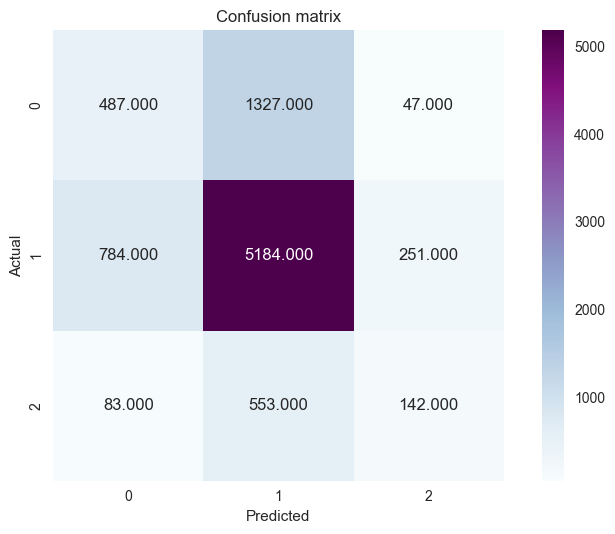

In [747]:
#Visualizing the confusion matrix
sns.set_style("darkgrid")
sns.heatmap(confusion_matrix, annot = True, fmt = ".3f", square = True,cmap="BuPu")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [748]:
#Printing the  Classification Report
print("Classification Report for XGB Classifier Model\n")
print(classification_report(y_test,y_pred_test))

Classification Report for XGB Classifier Model

              precision    recall  f1-score   support

           0       0.36      0.26      0.30      1861
           1       0.73      0.83      0.78      6219
           2       0.32      0.18      0.23       778

    accuracy                           0.66      8858
   macro avg       0.47      0.43      0.44      8858
weighted avg       0.62      0.66      0.63      8858



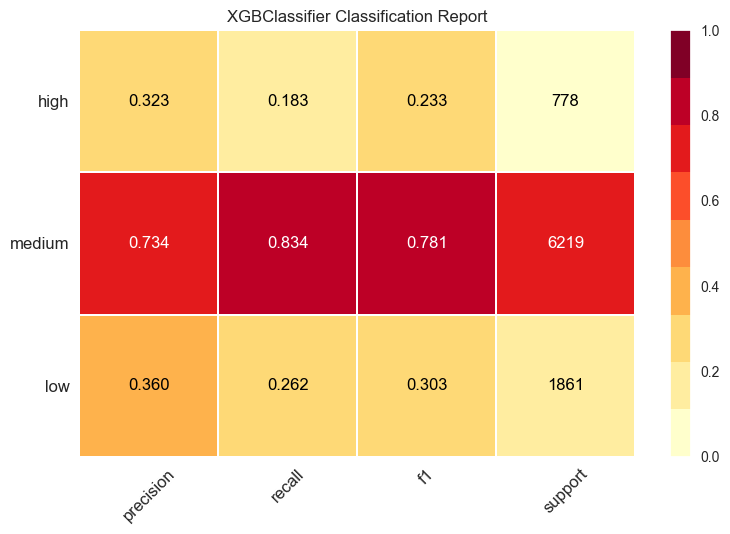

<AxesSubplot: title={'center': 'XGBClassifier Classification Report'}>

In [749]:
#Visualizing the classification report
from yellowbrick.classifier import ClassificationReport

classes=['low','medium', 'high']

visualizer = ClassificationReport(model_xgb_crime, classes=classes, support=True)
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

In [750]:
#Visualizing the predicted classes
count0 = 0
count1 = 0
count2 = 0
for i in y_pred_test:
    if i == 1:
        count1 += 1
    if i == 0:
        count0 += 1
    if i == 2:
        count2 += 1
predicted = []
predicted.append(count0)
predicted.append(count1)
predicted.append(count2)

In [751]:
### predicted count of each class
predicted

[1354, 7064, 440]

In [752]:
import matplotlib.pyplot as plt
class_names = ["Low","Medium","High"]

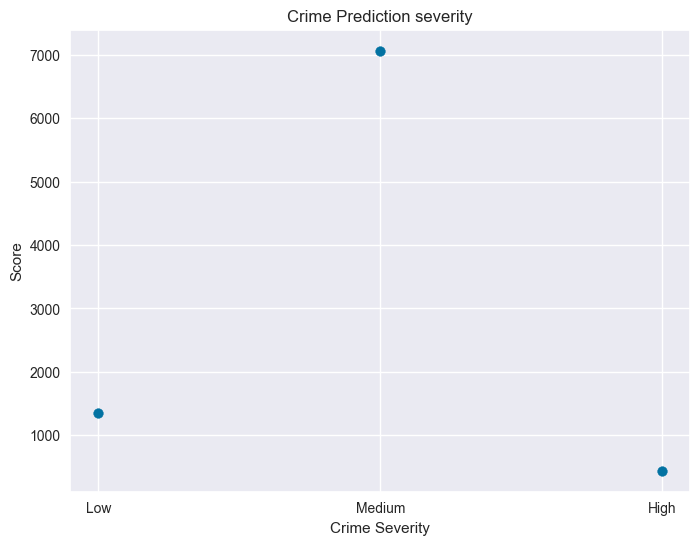

In [753]:
#Print bar graph for the predicted classes of severity
plt.figure(figsize=(8, 6))
plt.scatter(class_names,predicted)
plt.title("Crime Prediction severity")

# Labels for x and y axis
plt.xlabel("Crime Severity")
plt.ylabel("Score")
plt.show()


### Observation : We see Medium rate severity of crimes occuring at most of the locations 

### Results of XGBoost Classifier model

#### The model achieved an accuracy of  90% for train data
#### The model achieved an accuracy of  65% for test data
#### The model achieved an accuracy of  65% for validation data


## Model 2 : AdaBoostClassifier with DecisionTree 

## AdaBoost Classifier for predicting the crime rate severity at a location and time

In [754]:
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [755]:
#Loading the dataset
#crimes_df = pd.read_csv('C:/Users/ksidda2/Downloads/Crimes-2019_to_2021.csv')
crimes_df = pd.read_csv('Crimes-2019_to_2021.csv')
crimes_df.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11552667,JC100123,1/1/19 0:00,004XX N STATE ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,42.0,8.0,6,1176302.0,1903096.0,2019,1/10/19 15:16,41.889453,-87.627995,"(41.889453169, -87.627994833)"
1,11552674,JC100085,1/1/19 0:00,092XX S NORMAL AVE,910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,21.0,73.0,7,1174586.0,1843723.0,2019,1/10/19 15:16,41.726566,-87.636066,"(41.726566477, -87.636065622)"
2,11552709,JC100020,1/1/19 0:00,044XX S WASHTENAW AVE,486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,15.0,58.0,08B,1159112.0,1875020.0,2019,1/10/19 15:16,41.812780,-87.691894,"(41.812780011, -87.691893746)"
3,11552758,JC100058,1/1/19 0:00,063XX S MARSHFIELD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,16.0,67.0,14,1166414.0,1862607.0,2019,1/10/19 15:16,41.778565,-87.665464,"(41.77856457, -87.665463557)"
4,11553168,JC100745,1/1/19 0:00,008XX N MICHIGAN AVE,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,2.0,8.0,6,1177330.0,1906499.0,2019,1/10/19 15:16,41.898768,-87.624116,"(41.898767916, -87.624116333)"


In [756]:
# Converting the data column to datetime object so we can get better results of our analysis
# Get the day of the week,month and hour of the crimes

crimes_df.Date = pd.to_datetime(crimes_df.Date)
crimes_df['Day'] =pd.to_datetime(crimes_df.Date).dt.day_name()
crimes_df['Month'] = pd.to_datetime(crimes_df.Date).dt.month_name()
crimes_df['Hour'] = pd.to_datetime(crimes_df.Date).dt.hour

In [757]:
#Converting the respective features to categorical type using astype and .cat.codes
crimes_df['Primary Type'] = crimes_df['Primary Type'].astype('category')
crimes_df['Primary Type'] = crimes_df['Primary Type'].cat.codes

crimes_df['Month'] = crimes_df['Month'].astype('category')
crimes_df['Month'] = crimes_df['Month'].cat.codes

crimes_df['Day'] = crimes_df['Day'].astype('category')
crimes_df['Day'] = crimes_df['Day'].cat.codes

crimes_df['District'] = crimes_df['District'].astype('category')
crimes_df['District'] = crimes_df['District'].cat.codes

In [758]:
#Drop thr error location coordinates
crimes_df[['X Coordinate', 'Y Coordinate']] = crimes_df[['X Coordinate', 'Y Coordinate']].replace(0.0, np.nan)
crimes_df.dropna(inplace=True)

In [759]:
#Renaming column names to lower case and filling spaces with underscores.
crimes_df.columns = crimes_df.columns.str.strip()
crimes_df.columns = crimes_df.columns.str.replace(' ', '_')
crimes_df.columns = crimes_df.columns.str.lower()

In [760]:
#Dropping the duplicate rows in the dataset with dropdupicates() to avoid inconsistencies
crimes_df=crimes_df.drop_duplicates()

In [761]:


#Extracting the required features for the model 
features = ['day','month','hour','district', 'primary_type']
temp_df = crimes_df[features]
temp_df.head()

,day,month,hour,district,primary_type
0,5,4,0,16,31
1,5,4,0,19,17
2,5,4,0,8,2
3,5,4,0,6,6
4,5,4,0,16,31


In [762]:


#Making a new dataframe for the model with the features day, district, month and hour, primary_type, by performing group by on 4 below columns and aggregating with primary_type mean 
crimes_df_ada = temp_df.groupby(['day','district','month','hour'], as_index=False).agg({"primary_type":'mean'})
crimes_df_ada = crimes_df_ada.sort_values(by=['district'], ascending=False)
crimes_df_ada.head()


,day,district,month,hour,primary_type
44286,6,22,11,8,6.0
18984,2,22,3,12,9.0
12653,1,22,2,12,2.0
25318,3,22,2,10,9.0
25319,3,22,4,0,1.0


In [763]:
crimes_df_ada['primary_type'].max().astype(int)

32

In [764]:

### There are total 33 unique values of primary crime type

In [765]:
#Final dataframe after performing label encoding on attributes
crimes_df_ada = crimes_df_ada[['month','day','hour','primary_type','district']]
crimes_df_ada.head()
crimes_df_ada.shape

(44287, 5)

In [766]:
crimes_df_ada['primary_type'].unique().astype(int)

array([ 6,  9,  2, ..., 23, 20, 24])

In [767]:

#Calculating The average number of crimes per district, per month, per day, per hour
print("The average number of crimes per district, per month, per day, per hour is ",int(crimes_df_ada['primary_type'].sum()/44287))

The average number of crimes per district, per month, per day, per hour is  14


In [768]:
#Create a new feature crime_severity by basing on average crimes obtained above 
def severity_feature(val):
    if(val <= 11):
        return 0
    elif(val > 11 and val <= 20):
        return 1
    else:
        return 2

In [769]:
#Creating the target feature column "crime_severity"
crimes_df_ada['crime_severity'] = crimes_df_ada['primary_type'].apply(severity_feature)
crimes_df_ada = crimes_df_ada[['month','day','hour','district','primary_type','crime_severity']]
crimes_df_ada.head()

,month,day,hour,district,primary_type,crime_severity
44286,11,6,8,22,6.0,0
18984,3,2,12,22,9.0,0
12653,2,1,12,22,2.0,0
25318,2,3,10,22,9.0,0
25319,4,3,0,22,1.0,0


### Making crime_severity as the target feature with crime_severity rate 0 , 1 and 2 indicating low, medium and high crime rate


In [770]:
#Define X and Y values

#Features which are independent
X = crimes_df_ada[['month', 'day', 'hour','district']] 
#Feature which is our target and dependent on above features
y = crimes_df_ada['crime_severity']

X = X.to_numpy()
y = y.to_numpy()

In [771]:
#Split the data into test and train set with train size as 80% and test size as 20%
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

X_trainval.shape, X_test.shape, y_trainval.shape, y_test.shape

((35429, 4), (8858, 4), (35429,), (8858,))

In [772]:
X_trainval.shape, X_test.shape, y_trainval.shape, y_test.shape, X_val.shape, y_val.shape

((35429, 4), (8858, 4), (35429,), (8858,), (7086, 4), (7086,))

In [773]:
#Applying the model and fitting the model
from sklearn.ensemble import RandomForestClassifier
model_ada_crime = AdaBoostClassifier()
model_ada_crime = model_ada_crime.fit(X_train, y_train)

In [774]:

#Making predictions on the AdaBoostClassifier model using Validation and test data
y_pred_val = model_ada_crime.predict(X_val)
y_pred_test = model_ada_crime.predict(X_test)
y_pred_train = model_ada_crime.predict(X_train)

In [775]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
print("Accuracy for the train data:",(metrics.accuracy_score(y_train, y_pred_train)*100),"\n")
print("Accuracy for the test data:",(metrics.accuracy_score(y_test, y_pred_test)*100),"\n")
print("Accuracy for the validation data:",(metrics.accuracy_score(y_val, y_pred_val)*100),"\n")

Accuracy for the train data: 68.86356419574498 

Accuracy for the test data: 69.18040189659065 

Accuracy for the validation data: 69.10810047981937 



In [776]:
confusion_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual Severity'], colnames=['Predicted Severity'])
print("\nConfusion Matrix for AdaBoost Classifier")
print(confusion_matrix)


Confusion Matrix for AdaBoost Classifier
Predicted Severity    0     1   2
Actual Severity                  
0                   359  1491  11
1                   411  5755  53
2                    51   713  14


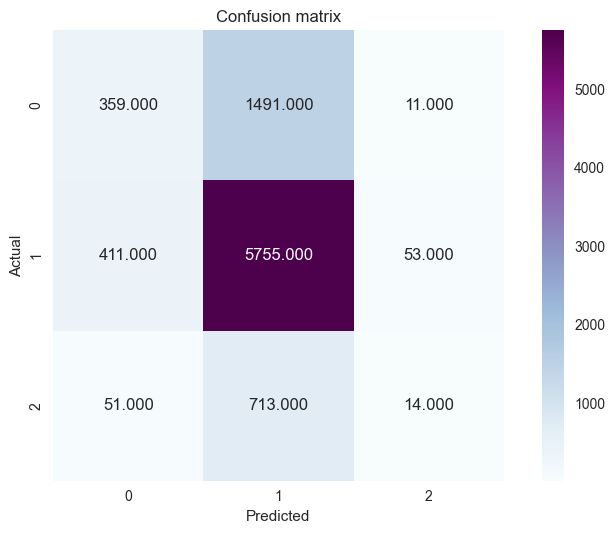

In [777]:

#Visualizing the confusion matrix
sns.set_style("darkgrid")
sns.heatmap(confusion_matrix, annot = True, fmt = ".3f", square = True,cmap="BuPu")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [778]:

#Printing the  Classification Report
print("Classification Report for AdaBoost Classifier Model\n")
print(classification_report(y_test,y_pred_test))


Classification Report for AdaBoost Classifier Model

              precision    recall  f1-score   support

           0       0.44      0.19      0.27      1861
           1       0.72      0.93      0.81      6219
           2       0.18      0.02      0.03       778

    accuracy                           0.69      8858
   macro avg       0.45      0.38      0.37      8858
weighted avg       0.62      0.69      0.63      8858



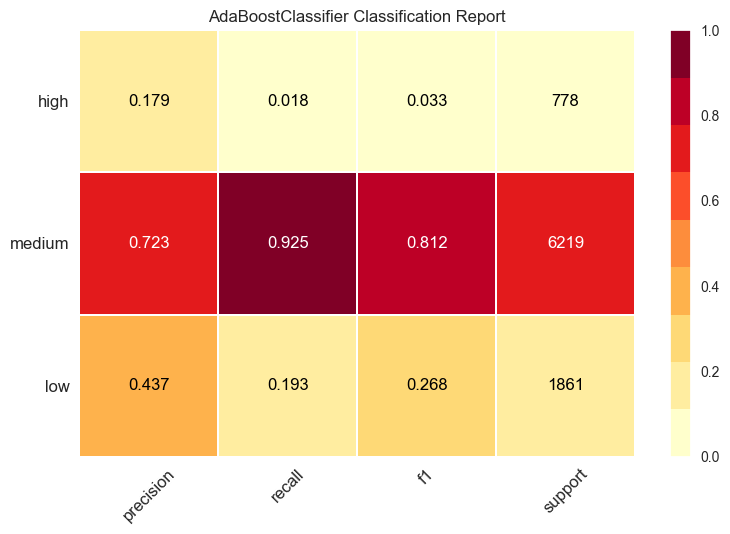

<AxesSubplot: title={'center': 'AdaBoostClassifier Classification Report'}>

In [779]:
#Visualizing the classification report
from yellowbrick.classifier import ClassificationReport

classes=['low','medium', 'high']

visualizer = ClassificationReport(model_ada_crime, classes=classes, support=True)
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

### Results of AdaBoost Classifier model

The model achieved an accuracy of  68% for train data  
The model achieved an accuracy of  69% for test data  
The model achieved an accuracy of  69% for validation data  